# SwaV Pre train - Creating Combinations of Backbone

### Inicialization and Loading Data of Pretext DATA

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
!pip install lightly --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.5/745.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.2/812.2 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 24.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
%cd /content/drive/MyDrive/HAR_WORK/HAR/

/content/drive/MyDrive/HAR_WORK/HAR


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import matplotlib.pyplot as plt
from lightly.loss import SwaVLoss
from lightly.models.modules import SwaVProjectionHead, SwaVPrototypes
import torch.nn.functional as F

# SwAV model
class SwaV(nn.Module):
    def __init__(self, backbone, n_prototypes):
        super().__init__()
        self.backbone = backbone
        self.projection_head = SwaVProjectionHead(128, 128, 64)
        self.prototypes = SwaVPrototypes(64, n_prototypes=n_prototypes)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        x = self.projection_head(x)
        x = nn.functional.normalize(x, dim=1, p=2)
        p = self.prototypes(x)
        return p

# Conv1D backbone for multi-feature time series
class Conv1DBackbone(nn.Module):
    def __init__(self, conv1_params, conv2_params, conv3_params):
        super().__init__()
        self.conv1 = nn.Conv1d(*conv1_params)
        self.conv2 = nn.Conv1d(*conv2_params)
        self.conv3 = nn.Conv1d(*conv3_params)
        self.pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.conv3(x)
        x = nn.ReLU()(x)
        x = self.pool(x)
        return x

# Custom data augmentation for time series with multiple features
def augment_time_series(data):
    # Random time shift
    shift = np.random.randint(1, data.shape[1])
    shifted_data = np.roll(data, shift, axis=1)

    # Adding random noise
    noise = np.random.normal(0, 0.01, data.shape)
    noisy_data = data + noise

    # Scaling
    scale = np.random.uniform(0.8, 1.2)
    scaled_data = data * scale

    # Random permutation
    permuted_data = np.random.permutation(data.T).T

    # Choose a random augmentation
    augmented_data = random.choice([shifted_data, noisy_data, scaled_data, permuted_data])
    return augmented_data

# Subsampling function for low resolution
def subsample(data, factor=2):
    return data[:, ::factor]

# Custom dataset for multi-feature time series
class TimeSeriesDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return torch.tensor(sample, dtype=torch.float32), 0

# Load data
path = './data_clean.npy'
data = np.load(path)

# Split data into train and validation sets
train_size = int(0.8 * len(data))
val_size = len(data) - train_size
train_data, val_data = torch.utils.data.random_split(data, [train_size, val_size])

# Custom dataloaders
train_dataset = TimeSeriesDataset(train_data, transform=augment_time_series)
val_dataset = TimeSeriesDataset(val_data)

batch_size = 128
dataloader_train = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=8
)

dataloader_val = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=8
)

# Function to train and evaluate model
def train_and_evaluate(conv_params, n_prototypes, lr, model_name):
    # Initialize SwAV model with Conv1D backbone
    backbone = Conv1DBackbone(*conv_params)
    model = SwaV(backbone, n_prototypes)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    # Loss function and optimizer
    criterion = SwaVLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Early stopping parameters
    patience = 4  # Number of epochs to wait for improvement
    early_stopping_counter = 0
    best_val_loss = float('inf')

    # Training and validation loop
    print(f"Starting Training for {model_name}")
    num_epochs = 50
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training loop
        model.train()
        total_train_loss = 0
        for batch in dataloader_train:
            views = batch[0].to(device)
            model.prototypes.normalize()

            # Generate high resolution views (original and augmented)
            high_resolution_views = [views, torch.tensor(augment_time_series(views.cpu().numpy()), dtype=torch.float32).to(device)]

            # Generate low resolution views (subsampled)
            low_resolution_views = [subsample(view.cpu().numpy()) for view in high_resolution_views]
            low_resolution_views = [torch.tensor(view, dtype=torch.float32).to(device) for view in low_resolution_views]

            # Apply bilinear upscaling
            low_resolution_views = [F.interpolate(view.unsqueeze(1), size=(views.size(1), views.size(2)), mode='bilinear').squeeze(1) for view in low_resolution_views]

            # Combine and permute to match expected input shape
            all_views = high_resolution_views + low_resolution_views
            all_views = [view.permute(0, 2, 1) for view in all_views]  # (batch_size, channels, time_steps)

            # Apply the model to the augmented views
            multi_crop_features = [model(view) for view in all_views]
            high_resolution = multi_crop_features[:2]
            low_resolution = multi_crop_features[2:]

            loss = criterion(high_resolution, low_resolution)
            total_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        avg_train_loss = total_train_loss / len(dataloader_train)
        train_losses.append(avg_train_loss)

        # Validation loop
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in dataloader_val:
                views = batch[0].to(device)
                model.prototypes.normalize()

                # Generate high resolution views (original and augmented)
                high_resolution_views = [views, torch.tensor(augment_time_series(views.cpu().numpy()), dtype=torch.float32).to(device)]

                # Generate low resolution views (subsampled)
                low_resolution_views = [subsample(view.cpu().numpy()) for view in high_resolution_views]
                low_resolution_views = [torch.tensor(view, dtype=torch.float32).to(device) for view in low_resolution_views]

                # Apply bilinear upscaling
                low_resolution_views = [F.interpolate(view.unsqueeze(1), size=(views.size(1), views.size(2)), mode='bilinear').squeeze(1) for view in low_resolution_views]

                # Combine and permute to match expected input shape
                all_views = high_resolution_views + low_resolution_views
                all_views = [view.permute(0, 2, 1) for view in all_views]  # (batch_size, channels, time_steps)

                # Apply the model to the augmented views
                multi_crop_features = [model(view) for view in all_views]
                high_resolution = multi_crop_features[:2]
                low_resolution = multi_crop_features[2:]

                loss = criterion(high_resolution, low_resolution)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(dataloader_val)
        val_losses.append(avg_val_loss)

        print(f"Epoch: {epoch:>02}, Train Loss: {avg_train_loss:.5f}, Validation Loss: {avg_val_loss:.5f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping at epoch {epoch}. Best validation loss: {best_val_loss:.5f}")
                break

    # Plotting the losses
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Loss Curve for {model_name}')
    plt.savefig(f'{model_name}_loss_curve.png')
    plt.close()

    # Save the model
    torch.save(backbone.state_dict(), f'{model_name}_backbone.pth')
    print(f'{model_name} saved successfully.')

# Define configurations
conv_params_list = [
    [(6, 32, 8, 2, 3), (32, 64, 5, 2, 2), (64, 128, 3, 2, 1)],
    [(6, 64, 8, 2, 3), (64, 128, 5, 2, 2), (128, 128, 3, 2, 1)]
]

n_prototypes_list = [16, 32, 64]
lr_list = [0.001, 0.0001]

# Train and evaluate for each combination
for conv_params in conv_params_list:
    for n_prototypes in n_prototypes_list:
        for lr in lr_list:
            model_name = f'Conv_{conv_params[0][1]}_{conv_params[1][1]}_{conv_params[2][1]}_Prototypes_{n_prototypes}_LR_{lr}'
            train_and_evaluate(conv_params, n_prototypes, lr, model_name)


Starting Training for Conv_32_64_128_Prototypes_16_LR_0.001
Epoch: 00, Train Loss: 1.14192, Validation Loss: 1.53221
Epoch: 01, Train Loss: 0.80165, Validation Loss: 1.12087
Epoch: 02, Train Loss: 0.80083, Validation Loss: 0.82874
Epoch: 03, Train Loss: 0.83273, Validation Loss: 0.80530
Epoch: 04, Train Loss: 0.75448, Validation Loss: 0.96860
Epoch: 05, Train Loss: 0.69216, Validation Loss: 0.66932
Epoch: 06, Train Loss: 0.63194, Validation Loss: 0.68329
Epoch: 07, Train Loss: 0.60762, Validation Loss: 0.83204
Epoch: 08, Train Loss: 0.59521, Validation Loss: 0.87688
Epoch: 09, Train Loss: 0.64009, Validation Loss: 0.67745
Early stopping at epoch 9. Best validation loss: 0.66932
Conv_32_64_128_Prototypes_16_LR_0.001 saved successfully.
Starting Training for Conv_32_64_128_Prototypes_16_LR_0.0001
Epoch: 00, Train Loss: 1.33093, Validation Loss: 1.56377
Epoch: 01, Train Loss: 0.92478, Validation Loss: 1.84016
Epoch: 02, Train Loss: 0.81057, Validation Loss: 1.76992
Epoch: 03, Train Loss: 

In [ ]:
# SwAV model
from lightly.models.modules import SwaVProjectionHead, SwaVPrototypes
class SwaV(nn.Module):
    def __init__(self, backbone, n_prototypes):
        super().__init__()
        self.backbone = backbone
        self.projection_head = SwaVProjectionHead(128, 128, 64)
        self.prototypes = SwaVPrototypes(64, n_prototypes=n_prototypes)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        x = self.projection_head(x)
        x = nn.functional.normalize(x, dim=1, p=2)
        p = self.prototypes(x)
        return p

# Conv1D backbone for multi-feature time series
class Conv1DBackbone(nn.Module):
    def __init__(self, conv1_params, conv2_params, conv3_params):
        super().__init__()
        self.conv1 = nn.Conv1d(*conv1_params)
        self.conv2 = nn.Conv1d(*conv2_params)
        self.conv3 = nn.Conv1d(*conv3_params)
        self.pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.conv3(x)
        x = nn.ReLU()(x)
        x = self.pool(x)
        return x

# Custom data augmentation for time series with multiple features
def augment_time_series(data):
    # Random time shift
    shift = np.random.randint(1, data.shape[1])
    shifted_data = np.roll(data, shift, axis=1)

    # Adding random noise
    noise = np.random.normal(0, 0.01, data.shape)
    noisy_data = data + noise

    # Scaling
    scale = np.random.uniform(0.8, 1.2)
    scaled_data = data * scale

    # Random permutation
    permuted_data = np.random.permutation(data.T).T

    # Choose a random augmentation
    augmented_data = random.choice([shifted_data, noisy_data, scaled_data, permuted_data])
    return augmented_data

# Subsampling function for low resolution
def subsample(data, factor=2):
    return data[:, ::factor]

# Custom dataset for multi-feature time series
class TimeSeriesDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return torch.tensor(sample, dtype=torch.float32), 0

# Load data
path = './data_clean.npy'
data = np.load(path)

# Split data into train and validation sets
train_size = int(0.8 * len(data))
val_size = len(data) - train_size
train_data, val_data = torch.utils.data.random_split(data, [train_size, val_size])

# Custom dataloaders
train_dataset = TimeSeriesDataset(train_data, transform=augment_time_series)
val_dataset = TimeSeriesDataset(val_data)

batch_size = 128
dataloader_train = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=8
)

dataloader_val = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=8
)

class SwaV(nn.Module):
    def __init__(self, backbone, n_prototypes):
        super().__init__()
        self.backbone = backbone
        self.projection_head = SwaVProjectionHead(128, 128, 64)
        self.prototypes = SwaVPrototypes(64, n_prototypes=n_prototypes)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        x = self.projection_head(x)
        x = nn.functional.normalize(x, dim=1, p=2)
        p = self.prototypes(x)
        return p


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Example of Implementation

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.3, random_state=42)

dataset_train = TimeSeriesDataset(train_data, transform=augment_time_series)

dataset_val = TimeSeriesDataset(val_data, transform=augment_time_series)



dataloader_train = DataLoader(
    dataset_train,
    batch_size=128,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

dataloader_val = DataLoader(
    dataset_val,
    batch_size=128,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

In [4]:
import torch
from torch import nn
from lightly.models.modules import SwaVProjectionHead, SwaVPrototypes
# Definição do backbone Conv1D
class Conv1DBackbone(nn.Module):
    def __init__(self, conv1_params, conv2_params, conv3_params):
        super().__init__()
        self.conv1 = nn.Conv1d(*conv1_params)
        self.conv2 = nn.Conv1d(*conv2_params)
        self.conv3 = nn.Conv1d(*conv3_params)
        self.pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.conv3(x)
        x = nn.ReLU()(x)
        x = self.pool(x)
        return x

# Parâmetros do backbone que deseja carregar
conv_params = [(6, 64, 8, 2, 3), (64, 128, 5, 2, 2), (128, 128, 3, 2, 1)]

# Inicializar o backbone
backbone = Conv1DBackbone(*conv_params)

# Caminho para o modelo salvo
model_name = 'Conv_64_128_128_Prototypes_32_LR_0.0001'  # Modifique conforme necessário
model_path = f'{model_name}_backbone.pth'

# Carregar os pesos salvos
backbone.load_state_dict(torch.load(model_path))

# Mover para o dispositivo apropriado
device = "cuda" if torch.cuda.is_available() else "cpu"
backbone.to(device)

# Definir o modelo SwAV com o backbone carregado
class SwaV(nn.Module):
    def __init__(self, backbone, n_prototypes):
        super().__init__()
        self.backbone = backbone
        self.projection_head = SwaVProjectionHead(128, 128, 64)
        self.prototypes = SwaVPrototypes(64, n_prototypes=n_prototypes)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        x = self.projection_head(x)
        x = nn.functional.normalize(x, dim=1, p=2)
        p = self.prototypes(x)
        return p

# Inicializar o modelo SwAV com o backbone carregado
n_prototypes = 32  # Modifique conforme necessário
model = SwaV(backbone, n_prototypes)

# Mover o modelo para o dispositivo apropriado
model.to(device)

# O modelo está pronto para ser usado
print("Modelo carregado e pronto para uso")


Modelo carregado e pronto para uso


In [ ]:
# Assuming you have already loaded the `data_clean.npy` into `data`
data = np.load('./data_clean.npy')

# Define the feature extraction function
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.backbone = model.backbone
        self.projection_head = model.projection_head

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        x = self.projection_head(x)
        x = nn.functional.normalize(x, dim=1, p=2)
        return x

# Initialize the feature extractor
feature_extractor = FeatureExtractor(model).to(device)

# Prepare the dataset and dataloader
class FullDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.tensor(sample, dtype=torch.float32)

full_dataset = FullDataset(data)
full_dataloader = DataLoader(
    full_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=8,
)

# Extract features
all_features = []
with torch.no_grad():
    for batch in full_dataloader:
        batch = batch.to(device).permute(0, 2, 1)  # Ensure correct input shape
        features = feature_extractor(batch)
        all_features.append(features.cpu().numpy())

# Concatenate all features
all_features = np.concatenate(all_features, axis=0)

# Now `all_features` contains the extracted feature vectors for the entire dataset

In [ ]:
labels_for_activities= np.load('./labels_activities.npy')
labels_for_activities.shape

import numpy as np

# Seu array original de rótulos
original_labels = labels_for_activities

# Cria um mapeamento dos valores originais para novos valores contíguos
unique_labels = np.unique(original_labels)
label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}

# Aplica o mapeamento ao array original
reordered_labels = np.array([label_mapping[label] for label in original_labels])

print("Original Labels:", original_labels)
print("Reordered Labels:", reordered_labels)

Original Labels: [ 0  0  0 ... 24 24 24]
Reordered Labels: [ 0  0  0 ... 12 12 12]


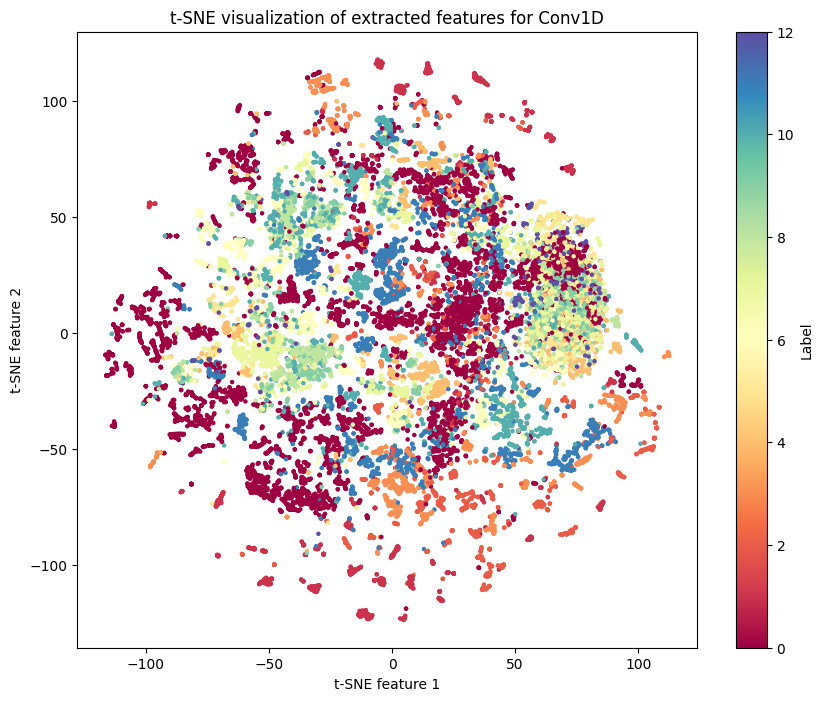

In [ ]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming `all_features` is already extracted as shown in the provided code snippet
# all_features = np.concatenate(all_features, axis=0)
labels = reordered_labels
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(all_features)

# Plot the t-SNE result
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, s=5, cmap='Spectral')
plt.title("t-SNE visualization of extracted features for Conv1D")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")
plt.colorbar(scatter, label='Label')
plt.show()

In [ ]:
### Loading HAR Data

# Downstream Task

In [5]:
pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.4 MB/s eta 0:00:00


In [6]:
from data_modules.har import HarDataModule

# Instantiating the HarDataModule with root dir at data/example
my_datamodule = HarDataModule(root_data_dir="data/har",
                              flatten = True,
                              target_column = "standard activity code",
                              batch_size=16)

In [7]:
import numpy as np

# Instanciando o HarDataModule
my_datamodule = HarDataModule(root_data_dir="data/har",
                              flatten=True,
                              target_column="standard activity code",
                              batch_size=16)

# Função para obter todos os dados e etiquetas de um DataLoader
def get_all_data_and_labels(dataloader):
    all_data = []
    all_labels = []
    for data, labels in dataloader:
        all_data.append(data.numpy())
        all_labels.append(labels.numpy())
    return np.vstack(all_data), np.concatenate(all_labels)

# Acessando os DataLoaders de treino e validação
train_loader = my_datamodule.train_dataloader()
val_loader = my_datamodule.val_dataloader()

# Obtendo todos os dados e etiquetas dos DataLoaders
X_train, y_train = get_all_data_and_labels(train_loader)
X_val, y_val = get_all_data_and_labels(val_loader)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)


Shape of X_train: (60, 360)
Shape of y_train: (60,)
Shape of X_val: (24, 360)
Shape of y_val: (24,)


In [8]:
train_dl = my_datamodule.train_dataloader()
val_dl = my_datamodule.val_dataloader()
test_dl = my_datamodule.test_dataloader()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import itertools
import re

# Função para obter todos os dados e etiquetas dos DataLoaders
def get_all_data_and_labels(dataloader):
    all_data = []
    all_labels = []
    for data, labels in dataloader:
        all_data.append(data)
        all_labels.append(labels)
    return torch.cat(all_data), torch.cat(all_labels)

# Definição da cabeça de predição MLP
class MLPHead(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPHead, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Definição do modelo downstream completo
class DownstreamModel(nn.Module):
    def __init__(self, backbone, head):
        super(DownstreamModel, self).__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        x = self.head(x)
        return x

# Função para treinar o modelo
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), 6, -1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Val Loss: {val_losses[-1]}, Val Accuracy: {val_accuracies[-1]}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Função para avaliar o modelo
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), 6, -1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

# Função para extrair hiperparâmetros do nome do arquivo
def extract_hyperparameters_from_filename(filename):
    pattern = r"Conv_(\d+)_(\d+)_(\d+)_Prototypes_(\d+)_LR_(0\.\d+)"
    match = re.match(pattern, filename)
    if match:
        conv_params = [
            (6, int(match.group(1)), 8, 2, 3),
            (int(match.group(1)), int(match.group(2)), 5, 2, 2),
            (int(match.group(2)), int(match.group(3)), 3, 2, 1)
        ]
        n_prototypes = int(match.group(4))
        lr = float(match.group(5))
        return conv_params, n_prototypes, lr
    else:
        raise ValueError("Filename does not match expected pattern")

# Função para executar o grid search
def grid_search(train_loader, val_loader, device, filenames):
    best_val_accuracy = 0.0
    best_params = None

    for filename in filenames:
        print(f"Testing with {filename}")

        # Extrair hiperparâmetros do nome do arquivo
        conv_params, n_prototypes, lr = extract_hyperparameters_from_filename(filename)

        # Carregar o backbone pré-treinado
        backbone = Conv1DBackbone(*conv_params)
        state_dict = torch.load(filename, map_location=device)
        backbone.load_state_dict(state_dict)
        backbone.eval()

        # Definir a cabeça de predição
        input_size = 128  # Ajuste conforme necessário
        num_classes = 6  # Número de classes para classificação
        head = MLPHead(input_size=input_size, num_classes=num_classes)
        model = DownstreamModel(backbone=backbone, head=head)

        # Congelar todas as camadas do backbone
        for param in model.backbone.parameters():
            param.requires_grad = False

        # Descongelar a cabeça do modelo
        for param in model.head.parameters():
            param.requires_grad = True

        # Definir otimizador e função de perda
        optimizer = optim.Adam(model.head.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Treinamento do modelo
        model.to(device)

        # Treinar a cabeça do modelo
        num_epochs = 50  # Defina o número de épocas conforme necessário
        train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

        # Fine-tuning do modelo
        for param in model.backbone.parameters():
            param.requires_grad = True

        num_fine_tuning_epochs = 5  # Defina o número de épocas de fine-tuning conforme necessário
        optimizer = optim.Adam(model.parameters(), lr=lr)
        train_losses_ft, val_losses_ft, train_accuracies_ft, val_accuracies_ft = train_model(model, train_loader, val_loader, criterion, optimizer, num_fine_tuning_epochs, device)

        # Concatenar os resultados de treinamento e fine-tuning
        train_losses += train_losses_ft
        val_losses += val_losses_ft
        train_accuracies += train_accuracies_ft
        val_accuracies += val_accuracies_ft

        # Avaliar o modelo na tarefa downstream
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_params = (conv_params, n_prototypes, lr, num_epochs, num_fine_tuning_epochs)

    print(f"Best parameters: conv_params={best_params[0]}, n_prototypes={best_params[1]}, lr={best_params[2]}, num_epochs={best_params[3]}, num_fine_tuning_epochs={best_params[4]} with validation accuracy: {best_val_accuracy}")

# Carregar os dados
train_loader = my_datamodule.train_dataloader()
val_loader = my_datamodule.test_dataloader()  # alternar para validação com a otimização dos ho

# Obter todos os dados e etiquetas dos DataLoaders
X_train, y_train = get_all_data_and_labels(train_loader)
X_val, y_val = get_all_data_and_labels(val_loader)

# Ajustar o formato dos dados de entrada para (batch_size, num_channels, sequence_length)
X_train = X_train.view(X_train.size(0), 6, -1)
X_val = X_val.view(X_val.size(0), 6, -1)

# Criar novos DataLoaders com os dados ajustados
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Defina os nomes dos arquivos de modelos salvos
filenames = [
    'Conv_32_64_128_Prototypes_16_LR_0.001_backbone.pth',
    'Conv_32_64_128_Prototypes_32_LR_0.001_backbone.pth',
    'Conv_32_64_128_Prototypes_64_LR_0.001_backbone.pth',
    'Conv_32_64_128_Prototypes_16_LR_0.0001_backbone.pth',
    'Conv_32_64_128_Prototypes_32_LR_0.0001_backbone.pth',
    'Conv_32_64_128_Prototypes_64_LR_0.0001_backbone.pth',
    'Conv_64_128_128_Prototypes_16_LR_0.001_backbone.pth',
    'Conv_64_128_128_Prototypes_32_LR_0.001_backbone.pth',
    'Conv_64_128_128_Prototypes_64_LR_0.001_backbone.pth',
    'Conv_64_128_128_Prototypes_16_LR_0.0001_backbone.pth',
    'Conv_64_128_128_Prototypes_32_LR_0.0001_backbone.pth',
    'Conv_64_128_128_Prototypes_64_LR_0.0001_backbone.pth'
]

# Executar o grid search
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
grid_search(train_loader, val_loader, device, filenames)


Testing with Conv_32_64_128_Prototypes_16_LR_0.001_backbone.pth
Epoch 1/50, Train Loss: 1.8768922984600067, Train Accuracy: 0.16666666666666666, Val Loss: 1.8325476050376892, Val Accuracy: 0.16666666666666666
Epoch 2/50, Train Loss: 1.7475172877311707, Train Accuracy: 0.2, Val Loss: 1.6648073196411133, Val Accuracy: 0.5
Epoch 3/50, Train Loss: 1.6352760791778564, Train Accuracy: 0.4666666666666667, Val Loss: 1.5421139001846313, Val Accuracy: 0.3333333333333333
Epoch 4/50, Train Loss: 1.577041745185852, Train Accuracy: 0.3333333333333333, Val Loss: 1.4557780623435974, Val Accuracy: 0.3333333333333333
Epoch 5/50, Train Loss: 1.5336202681064606, Train Accuracy: 0.35, Val Loss: 1.4048697352409363, Val Accuracy: 0.3333333333333333
Epoch 6/50, Train Loss: 1.4768418967723846, Train Accuracy: 0.3333333333333333, Val Loss: 1.3741893768310547, Val Accuracy: 0.3333333333333333
Epoch 7/50, Train Loss: 1.4557745158672333, Train Accuracy: 0.3333333333333333, Val Loss: 1.340333878993988, Val Accuracy

## For Validation Set with the Best Parameters

### Only Freeze

Epoch 1/100, Train Loss: 1.594127744436264, Train Accuracy: 0.2, Val Loss: 1.368540734052658, Val Accuracy: 0.3333333333333333
Epoch 2/100, Train Loss: 1.5316913723945618, Train Accuracy: 0.35, Val Loss: 1.337870717048645, Val Accuracy: 0.3333333333333333
Epoch 3/100, Train Loss: 1.4629037082195282, Train Accuracy: 0.36666666666666664, Val Loss: 1.30154550075531, Val Accuracy: 0.3333333333333333
Epoch 4/100, Train Loss: 1.44978529214859, Train Accuracy: 0.35, Val Loss: 1.2787703573703766, Val Accuracy: 0.3333333333333333
Epoch 5/100, Train Loss: 1.4300325214862823, Train Accuracy: 0.35, Val Loss: 1.2640503644943237, Val Accuracy: 0.3333333333333333
Epoch 6/100, Train Loss: 1.4103808999061584, Train Accuracy: 0.35, Val Loss: 1.260677844285965, Val Accuracy: 0.3333333333333333
Epoch 7/100, Train Loss: 1.3795890808105469, Train Accuracy: 0.36666666666666664, Val Loss: 1.2646663784980774, Val Accuracy: 0.3333333333333333
Epoch 8/100, Train Loss: 1.3636562526226044, Train Accuracy: 0.366666

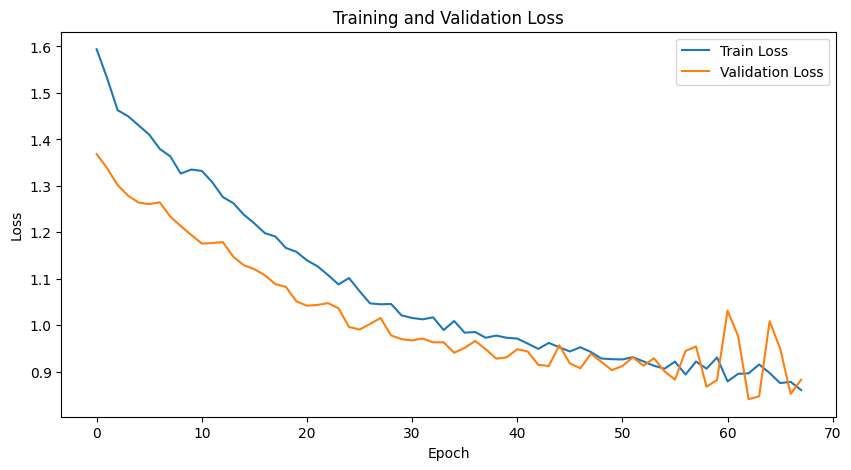

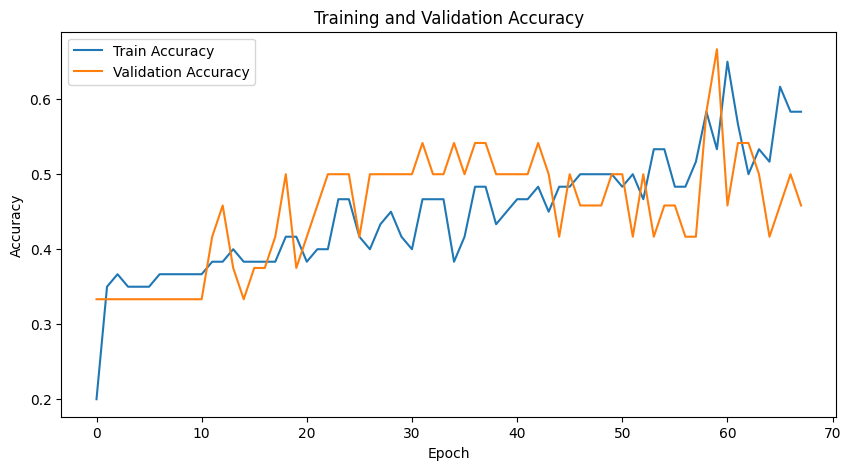

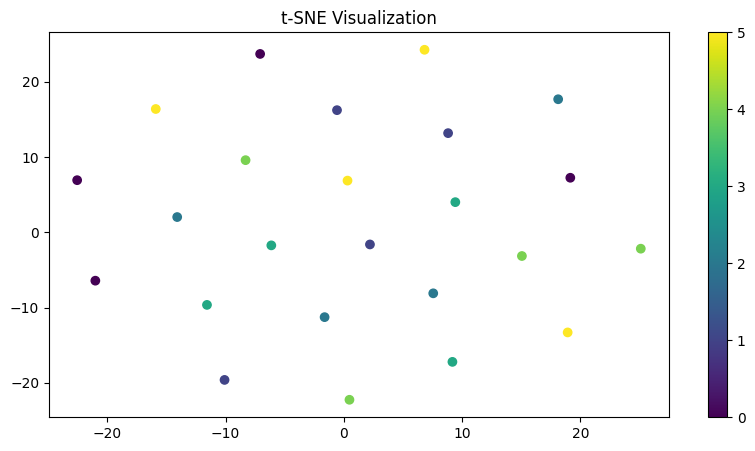

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random

# Função para definir a seed para reprodutibilidade
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Definir a seed
seed = 42
set_seed(seed)

# Função para obter todos os dados e etiquetas dos DataLoaders
def get_all_data_and_labels(dataloader):
    all_data = []
    all_labels = []
    for data, labels in dataloader:
        all_data.append(data)
        all_labels.append(labels)
    return torch.cat(all_data), torch.cat(all_labels)

# Definição da cabeça de predição MLP
class MLPHead(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPHead, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Definição do modelo downstream completo
class DownstreamModel(nn.Module):
    def __init__(self, backbone, head):
        super(DownstreamModel, self).__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        x = self.head(x)
        return x

# Função para treinar o modelo com early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), 6, -1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Val Loss: {val_losses[-1]}, Val Accuracy: {val_accuracies[-1]}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}. Best validation loss: {best_val_loss:.4f}")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies

# Função para avaliar o modelo
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), 6, -1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

# Função para extrair representações do modelo
def extract_representations(model, dataloader, device):
    model.eval()
    representations = []
    labels = []
    with torch.no_grad():
        for inputs, label in dataloader:
            inputs = inputs.to(device)
            inputs = inputs.view(inputs.size(0), 6, -1)
            reps = model.backbone(inputs).flatten(start_dim=1)
            representations.append(reps.cpu())
            labels.append(label)
    return torch.cat(representations), torch.cat(labels)

# Função para plotar t-SNE
def plot_tsne(representations, labels, perplexity=30):
    n_samples = representations.shape[0]
    # Ajusta perplexidade para ser menor que o número de amostras
    if perplexity >= n_samples:
        perplexity = n_samples - 1
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=300, random_state=seed)
    tsne_results = tsne.fit_transform(representations)

    plt.figure(figsize=(10, 5))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title('t-SNE Visualization')
    plt.show()

# Melhores hiperparâmetros encontrados
best_conv_params = [(6, 64, 8, 2, 3), (64, 128, 5, 2, 2), (128, 128, 3, 2, 1)]
best_n_prototypes = 32
best_lr = 0.001

# Carregar o backbone pré-treinado
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backbone = Conv1DBackbone(*best_conv_params)
state_dict = torch.load(f'Conv_{best_conv_params[0][1]}_{best_conv_params[1][1]}_{best_conv_params[2][1]}_Prototypes_{best_n_prototypes}_LR_{best_lr}_backbone.pth', map_location=device)
backbone.load_state_dict(state_dict)
backbone.eval()

# Definir a cabeça de predição
input_size = 128  # Ajuste conforme necessário
num_classes = 6  # Número de classes para classificação
head = MLPHead(input_size=input_size, num_classes=num_classes)
model = DownstreamModel(backbone=backbone, head=head)

# Acessar os DataLoaders de treino e validação
train_loader = my_datamodule.train_dataloader()
val_loader = my_datamodule.val_dataloader()

# Congelar todas as camadas do backbone
for param in model.backbone.parameters():
    param.requires_grad = False

# Descongelar a cabeça do modelo
for param in model.head.parameters():
    param.requires_grad = True

# Definir otimizador e função de perda
optimizer = optim.Adam(model.head.parameters(), lr=best_lr)
criterion = nn.CrossEntropyLoss()

# Treinamento do modelo
model.to(device)

# Definir o parâmetro de paciência para o early stopping
patience = 5

# Treinar a cabeça do modelo
num_epochs = 100
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, device)

# Avaliar o modelo na tarefa downstream
val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Plotar as perdas de treino e validação
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plotar as acurácias de treino e validação
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Extrair representações do modelo final
representations, labels = extract_representations(model, val_loader, device)

# Aplicar t-SNE e plotar as representações
plot_tsne(representations.numpy(), labels.numpy())


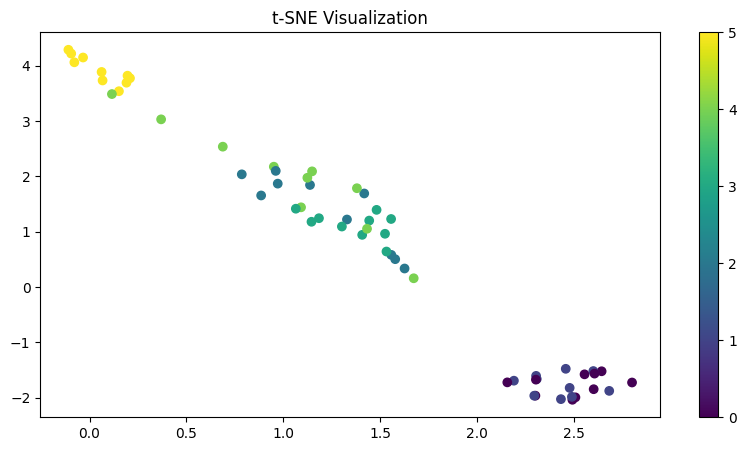

In [11]:
# Extrair representações do modelo final
representations, labels = extract_representations(model, train_dl, device)

# Aplicar t-SNE e plotar as representações
plot_tsne(representations.numpy(), labels.numpy())

### With Freeze and Fine Tunning

Epoch 1/100, Train Loss: 1.5828166007995605, Train Accuracy: 0.16666666666666666, Val Loss: 1.3697130382061005, Val Accuracy: 0.16666666666666666
Epoch 2/100, Train Loss: 1.4865941405296326, Train Accuracy: 0.16666666666666666, Val Loss: 1.3123186826705933, Val Accuracy: 0.3333333333333333
Epoch 3/100, Train Loss: 1.4649141430854797, Train Accuracy: 0.35, Val Loss: 1.292606145143509, Val Accuracy: 0.3333333333333333
Epoch 4/100, Train Loss: 1.449997067451477, Train Accuracy: 0.3333333333333333, Val Loss: 1.2678675055503845, Val Accuracy: 0.3333333333333333
Epoch 5/100, Train Loss: 1.409127652645111, Train Accuracy: 0.31666666666666665, Val Loss: 1.2567623257637024, Val Accuracy: 0.375
Epoch 6/100, Train Loss: 1.4058724343776703, Train Accuracy: 0.35, Val Loss: 1.2487671375274658, Val Accuracy: 0.3333333333333333
Epoch 7/100, Train Loss: 1.3805659413337708, Train Accuracy: 0.36666666666666664, Val Loss: 1.237410843372345, Val Accuracy: 0.3333333333333333
Epoch 8/100, Train Loss: 1.36913

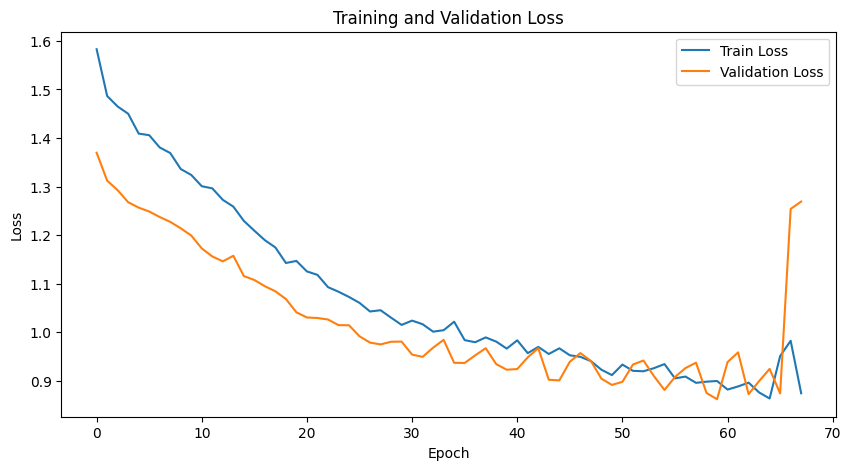

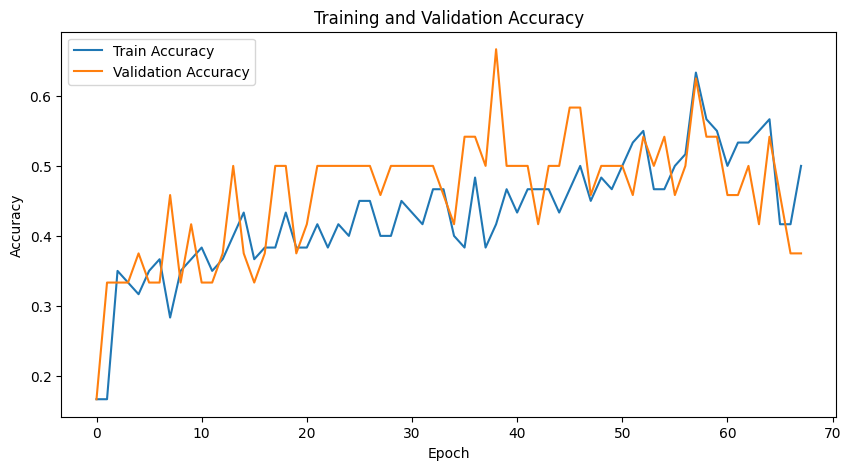

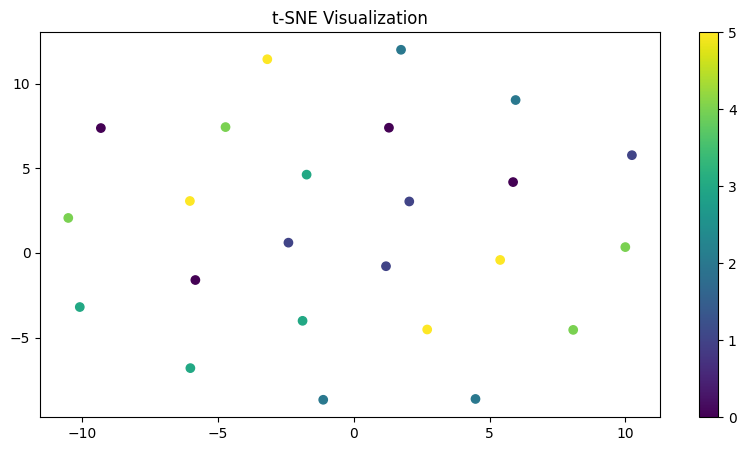

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random

# Função para definir a seed para reprodutibilidade
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Definir a seed
seed = 42
set_seed(seed)

# Função para obter todos os dados e etiquetas dos DataLoaders
def get_all_data_and_labels(dataloader):
    all_data = []
    all_labels = []
    for data, labels in dataloader:
        all_data.append(data)
        all_labels.append(labels)
    return torch.cat(all_data), torch.cat(all_labels)

# Definição da cabeça de predição MLP
class MLPHead(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPHead, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Definição do modelo downstream completo
class DownstreamModel(nn.Module):
    def __init__(self, backbone, head):
        super(DownstreamModel, self).__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        x = self.head(x)
        return x

# Função para treinar o modelo com early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), 6, -1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Val Loss: {val_losses[-1]}, Val Accuracy: {val_accuracies[-1]}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}. Best validation loss: {best_val_loss:.4f}")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies

# Função para avaliar o modelo
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), 6, -1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

# Função para extrair representações do modelo
def extract_representations(model, dataloader, device):
    model.eval()
    representations = []
    labels = []
    with torch.no_grad():
        for inputs, label in dataloader:
            inputs = inputs.to(device)
            inputs = inputs.view(inputs.size(0), 6, -1)
            reps = model.backbone(inputs).flatten(start_dim=1)
            representations.append(reps.cpu())
            labels.append(label)
    return torch.cat(representations), torch.cat(labels)

# Função para plotar t-SNE
def plot_tsne(representations, labels, perplexity=30):
    n_samples = representations.shape[0]
    # Ajusta perplexidade para ser menor que o número de amostras
    if perplexity >= n_samples:
        perplexity = n_samples - 1
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=300, random_state=seed)
    tsne_results = tsne.fit_transform(representations)

    plt.figure(figsize=(10, 5))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title('t-SNE Visualization')
    plt.show()

# Melhores hiperparâmetros encontrados
best_conv_params = [(6, 64, 8, 2, 3), (64, 128, 5, 2, 2), (128, 128, 3, 2, 1)]
best_n_prototypes = 32
best_lr = 0.001

# Carregar o backbone pré-treinado
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backbone = Conv1DBackbone(*best_conv_params)
state_dict = torch.load(f'Conv_{best_conv_params[0][1]}_{best_conv_params[1][1]}_{best_conv_params[2][1]}_Prototypes_{best_n_prototypes}_LR_{best_lr}_backbone.pth', map_location=device)
backbone.load_state_dict(state_dict)
backbone.eval()

# Definir a cabeça de predição
input_size = 128  # Ajuste conforme necessário
num_classes = 6  # Número de classes para classificação
head = MLPHead(input_size=input_size, num_classes=num_classes)
model = DownstreamModel(backbone=backbone, head=head)

# Acessar os DataLoaders de treino e validação
train_loader = my_datamodule.train_dataloader()
val_loader = my_datamodule.val_dataloader()

# Obter todos os dados e etiquetas dos DataLoaders
X_train, y_train = get_all_data_and_labels(train_loader)
X_val, y_val = get_all_data_and_labels(val_loader)

# Ajustar o formato dos dados de entrada para (batch_size, num_channels, sequence_length)
X_train = X_train.view(X_train.size(0), 6, -1)
X_val = X_val.view(X_val.size(0), 6, -1)

# Criar novos DataLoaders com os dados ajustados
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Congelar todas as camadas do backbone
for param in model.backbone.parameters():
    param.requires_grad = False

# Descongelar a cabeça do modelo
for param in model.head.parameters():
    param.requires_grad = True

# Definir otimizador e função de perda
optimizer = optim.Adam(model.head.parameters(), lr=best_lr)
criterion = nn.CrossEntropyLoss()

# Treinamento do modelo
model.to(device)

# Definir o parâmetro de paciência para o early stopping
patience = 5

# Treinar a cabeça do modelo
num_epochs = 100
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, device)

# Fine-tuning do modelo
for param in model.backbone.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=best_lr)
num_fine_tuning_epochs = 3
train_losses_ft, val_losses_ft, train_accuracies_ft, val_accuracies_ft = train_model(model, train_loader, val_loader, criterion, optimizer, num_fine_tuning_epochs, patience, device)

# Concatenar os resultados de treinamento e fine-tuning
train_losses += train_losses_ft
val_losses += val_losses_ft
train_accuracies += train_accuracies_ft
val_accuracies += val_accuracies_ft

# Avaliar o modelo na tarefa downstream
val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Plotar as perdas de treino e validação
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plotar as acurácias de treino e validação
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Extrair representações do modelo final
representations, labels = extract_representations(model, val_loader, device)

# Aplicar t-SNE e plotar as representações
plot_tsne(representations.numpy(), labels.numpy())

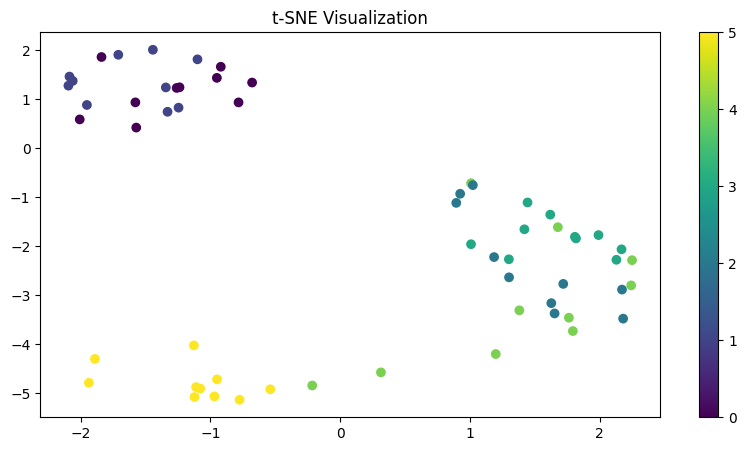

In [13]:
# Extrair representações do modelo final
representations, labels = extract_representations(model, train_dl, device)

# Aplicar t-SNE e plotar as representações
plot_tsne(representations.numpy(), labels.numpy())

## For Test Set with the Best Parameters

### With Freeze and Fine Tunning for Data Test

Epoch 1/100, Train Loss: 1.5828166007995605, Train Accuracy: 0.16666666666666666, Test Loss: 1.3827449083328247, Test Accuracy: 0.16666666666666666
Epoch 2/100, Train Loss: 1.4865941405296326, Train Accuracy: 0.16666666666666666, Test Loss: 1.3329385221004486, Test Accuracy: 0.3333333333333333
Epoch 3/100, Train Loss: 1.4649141430854797, Train Accuracy: 0.35, Test Loss: 1.2931423783302307, Test Accuracy: 0.3333333333333333
Epoch 4/100, Train Loss: 1.449997067451477, Train Accuracy: 0.3333333333333333, Test Loss: 1.2961512207984924, Test Accuracy: 0.3333333333333333
Epoch 5/100, Train Loss: 1.409127652645111, Train Accuracy: 0.31666666666666665, Test Loss: 1.282619684934616, Test Accuracy: 0.20833333333333334
Epoch 6/100, Train Loss: 1.4058724343776703, Train Accuracy: 0.35, Test Loss: 1.2615177631378174, Test Accuracy: 0.3333333333333333
Epoch 7/100, Train Loss: 1.3805659413337708, Train Accuracy: 0.36666666666666664, Test Loss: 1.2533642053604126, Test Accuracy: 0.3333333333333333
Epo

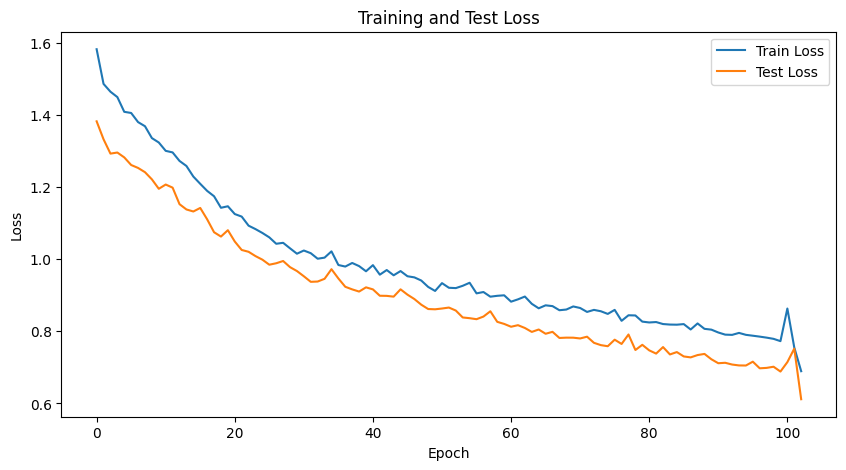

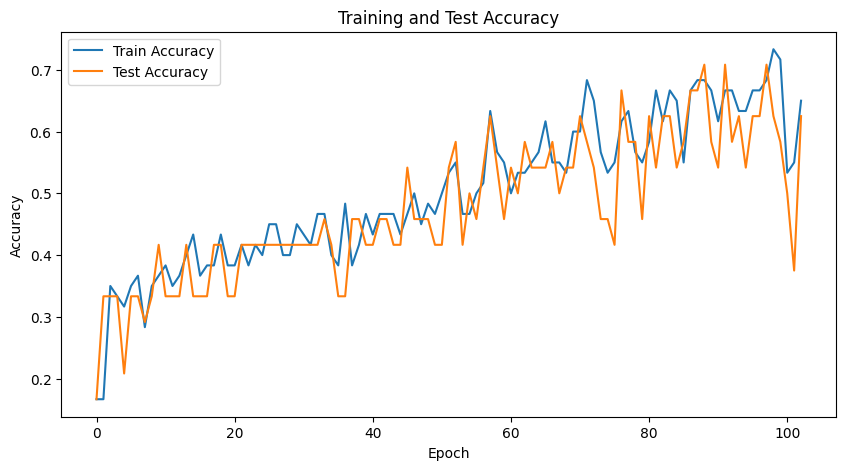

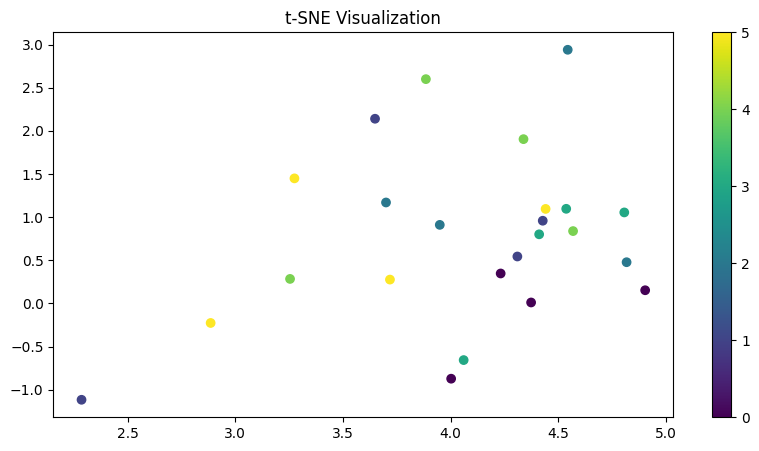

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random

# Função para definir a seed para reprodutibilidade
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Definir a seed
seed = 42
set_seed(seed)

# Função para obter todos os dados e etiquetas dos DataLoaders
def get_all_data_and_labels(dataloader):
    all_data = []
    all_labels = []
    for data, labels in dataloader:
        all_data.append(data)
        all_labels.append(labels)
    return torch.cat(all_data), torch.cat(all_labels)

# Definição da cabeça de predição MLP
class MLPHead(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPHead, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Definição do modelo downstream completo
class DownstreamModel(nn.Module):
    def __init__(self, backbone, head):
        super(DownstreamModel, self).__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        x = self.head(x)
        return x

# Função para treinar o modelo com early stopping
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, patience, device):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    best_test_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), 6, -1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Test Loss: {test_losses[-1]}, Test Accuracy: {test_accuracies[-1]}")

        # Early stopping check
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}. Best test loss: {best_test_loss:.4f}")
                break

    return train_losses, test_losses, train_accuracies, test_accuracies

# Função para avaliar o modelo
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), 6, -1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

# Função para extrair representações do modelo
def extract_representations(model, dataloader, device):
    model.eval()
    representations = []
    labels = []
    with torch.no_grad():
        for inputs, label in dataloader:
            inputs = inputs.to(device)
            inputs = inputs.view(inputs.size(0), 6, -1)
            reps = model.backbone(inputs).flatten(start_dim=1)
            representations.append(reps.cpu())
            labels.append(label)
    return torch.cat(representations), torch.cat(labels)

# Função para plotar t-SNE
def plot_tsne(representations, labels, perplexity=30):
    n_samples = representations.shape[0]
    # Ajusta perplexidade para ser menor que o número de amostras
    if perplexity >= n_samples:
        perplexity = n_samples - 1
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=300, random_state=seed)
    tsne_results = tsne.fit_transform(representations)

    plt.figure(figsize=(10, 5))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title('t-SNE Visualization')
    plt.show()

# Melhores hiperparâmetros encontrados
best_conv_params = [(6, 64, 8, 2, 3), (64, 128, 5, 2, 2), (128, 128, 3, 2, 1)]
best_n_prototypes = 32
best_lr = 0.001

# Carregar o backbone pré-treinado
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backbone = Conv1DBackbone(*best_conv_params)
state_dict = torch.load(f'Conv_{best_conv_params[0][1]}_{best_conv_params[1][1]}_{best_conv_params[2][1]}_Prototypes_{best_n_prototypes}_LR_{best_lr}_backbone.pth', map_location=device)
backbone.load_state_dict(state_dict)
backbone.eval()

# Definir a cabeça de predição
input_size = 128  # Ajuste conforme necessário
num_classes = 6  # Número de classes para classificação
head = MLPHead(input_size=input_size, num_classes=num_classes)
model = DownstreamModel(backbone=backbone, head=head)

# Acessar os DataLoaders de treino e teste
train_loader = my_datamodule.train_dataloader()
test_loader = my_datamodule.test_dataloader()

# Obter todos os dados e etiquetas dos DataLoaders
X_train, y_train = get_all_data_and_labels(train_loader)
X_test, y_test = get_all_data_and_labels(test_loader)

# Ajustar o formato dos dados de entrada para (batch_size, num_channels, sequence_length)
X_train = X_train.view(X_train.size(0), 6, -1)
X_test = X_test.view(X_test.size(0), 6, -1)

# Criar novos DataLoaders com os dados ajustados
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Congelar todas as camadas do backbone
for param in model.backbone.parameters():
    param.requires_grad = False

# Descongelar a cabeça do modelo
for param in model.head.parameters():
    param.requires_grad = True

# Definir otimizador e função de perda
optimizer = optim.Adam(model.head.parameters(), lr=best_lr)
criterion = nn.CrossEntropyLoss()

# Treinamento do modelo
model.to(device)

# Definir o parâmetro de paciência para o early stopping
patience = 5

# Treinar a cabeça do modelo
num_epochs = 100
train_losses, test_losses, train_accuracies, test_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, patience, device)

# Fine-tuning do modelo
for param in model.backbone.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=best_lr)
num_fine_tuning_epochs = 3
train_losses_ft, test_losses_ft, train_accuracies_ft, test_accuracies_ft = train_model(model, train_loader, test_loader, criterion, optimizer, num_fine_tuning_epochs, patience, device)

# Concatenar os resultados de treinamento e fine-tuning
train_losses += train_losses_ft
test_losses += test_losses_ft
train_accuracies += train_accuracies_ft
test_accuracies += test_accuracies_ft

# Avaliar o modelo na tarefa downstream
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Plotar as perdas de treino e teste
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')
plt.show()

# Plotar as acurácias de treino e teste
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Test Accuracy')
plt.show()

# Extrair representações do modelo final
representations, labels = extract_representations(model, test_loader, device)

# Aplicar t-SNE e plotar as representações
plot_tsne(representations.numpy(), labels.numpy())


### Only Freeze and Test Data

Epoch 1/100, Train Loss: 1.5941277146339417, Train Accuracy: 0.2, Test Loss: 1.3628687262535095, Test Accuracy: 0.3333333333333333
Epoch 2/100, Train Loss: 1.5316913723945618, Train Accuracy: 0.35, Test Loss: 1.3203561007976532, Test Accuracy: 0.375
Epoch 3/100, Train Loss: 1.4629036486148834, Train Accuracy: 0.36666666666666664, Test Loss: 1.3135056793689728, Test Accuracy: 0.3333333333333333
Epoch 4/100, Train Loss: 1.4497853219509125, Train Accuracy: 0.35, Test Loss: 1.3172188103199005, Test Accuracy: 0.3333333333333333
Epoch 5/100, Train Loss: 1.43003249168396, Train Accuracy: 0.35, Test Loss: 1.296362727880478, Test Accuracy: 0.3333333333333333
Epoch 6/100, Train Loss: 1.4103808999061584, Train Accuracy: 0.35, Test Loss: 1.2690155506134033, Test Accuracy: 0.3333333333333333
Epoch 7/100, Train Loss: 1.3795891106128693, Train Accuracy: 0.36666666666666664, Test Loss: 1.2631327509880066, Test Accuracy: 0.3333333333333333
Epoch 8/100, Train Loss: 1.3636561930179596, Train Accuracy: 0.

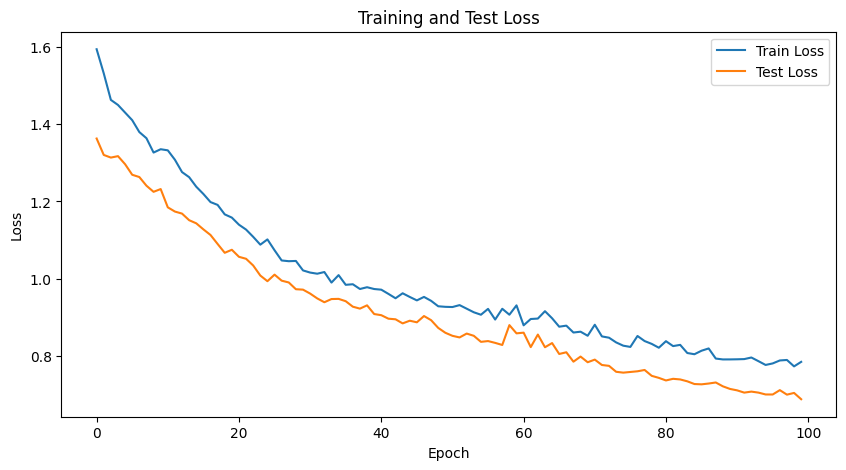

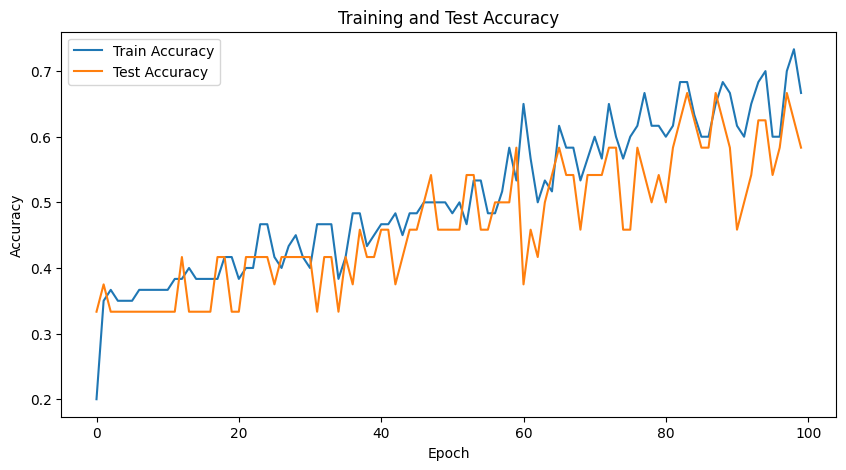

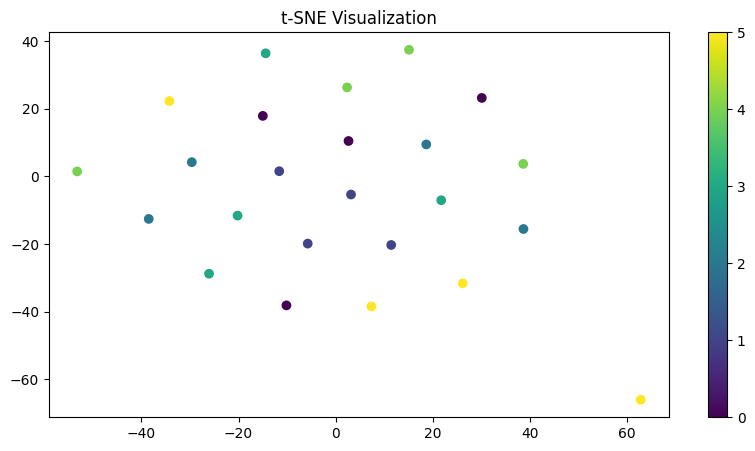

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random

# Função para definir a seed para reprodutibilidade
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Definir a seed
seed = 42
set_seed(seed)

# Função para obter todos os dados e etiquetas dos DataLoaders
def get_all_data_and_labels(dataloader):
    all_data = []
    all_labels = []
    for data, labels in dataloader:
        all_data.append(data)
        all_labels.append(labels)
    return torch.cat(all_data), torch.cat(all_labels)

# Definição da cabeça de predição MLP
class MLPHead(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPHead, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Definição do modelo downstream completo
class DownstreamModel(nn.Module):
    def __init__(self, backbone, head):
        super(DownstreamModel, self).__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        x = self.head(x)
        return x

# Função para treinar o modelo com early stopping
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, patience, device):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    best_test_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), 6, -1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Test Loss: {test_losses[-1]}, Test Accuracy: {test_accuracies[-1]}")

        # Early stopping check
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}. Best test loss: {best_test_loss:.4f}")
                break

    return train_losses, test_losses, train_accuracies, test_accuracies

# Função para avaliar o modelo
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), 6, -1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

# Função para extrair representações do modelo
def extract_representations(model, dataloader, device):
    model.eval()
    representations = []
    labels = []
    with torch.no_grad():
        for inputs, label in dataloader:
            inputs = inputs.to(device)
            inputs = inputs.view(inputs.size(0), 6, -1)
            reps = model.backbone(inputs).flatten(start_dim=1)
            representations.append(reps.cpu())
            labels.append(label)
    return torch.cat(representations), torch.cat(labels)

# Função para plotar t-SNE
def plot_tsne(representations, labels, perplexity=30):
    n_samples = representations.shape[0]
    # Ajusta perplexidade para ser menor que o número de amostras
    if perplexity >= n_samples:
        perplexity = n_samples - 1
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=300, random_state=seed)
    tsne_results = tsne.fit_transform(representations)

    plt.figure(figsize=(10, 5))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title('t-SNE Visualization')
    plt.show()

# Melhores hiperparâmetros encontrados
best_conv_params = [(6, 64, 8, 2, 3), (64, 128, 5, 2, 2), (128, 128, 3, 2, 1)]
best_n_prototypes = 32
best_lr = 0.001

# Carregar o backbone pré-treinado
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backbone = Conv1DBackbone(*best_conv_params)
state_dict = torch.load(f'Conv_{best_conv_params[0][1]}_{best_conv_params[1][1]}_{best_conv_params[2][1]}_Prototypes_{best_n_prototypes}_LR_{best_lr}_backbone.pth', map_location=device)
backbone.load_state_dict(state_dict)
backbone.eval()

# Definir a cabeça de predição
input_size = 128  # Ajuste conforme necessário
num_classes = 6  # Número de classes para classificação
head = MLPHead(input_size=input_size, num_classes=num_classes)
model = DownstreamModel(backbone=backbone, head=head)

# Acessar os DataLoaders de treino e teste
train_loader = my_datamodule.train_dataloader()
test_loader = my_datamodule.test_dataloader()

# Congelar todas as camadas do backbone
for param in model.backbone.parameters():
    param.requires_grad = False

# Descongelar a cabeça do modelo
for param in model.head.parameters():
    param.requires_grad = True

# Definir otimizador e função de perda
optimizer = optim.Adam(model.head.parameters(), lr=best_lr)
criterion = nn.CrossEntropyLoss()

# Treinamento do modelo
model.to(device)

# Definir o parâmetro de paciência para o early stopping
patience = 5

# Treinar a cabeça do modelo
num_epochs = 100
train_losses, test_losses, train_accuracies, test_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, patience, device)

# Avaliar o modelo na tarefa downstream
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Plotar as perdas de treino e teste
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')
plt.show()

# Plotar as acurácias de treino e teste
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Test Accuracy')
plt.show()

# Extrair representações do modelo final
representations, labels = extract_representations(model, test_loader, device)

# Aplicar t-SNE e plotar as representações
plot_tsne(representations.numpy(), labels.numpy())
